Sistema de recomendação de filmes utilizando filtro colaborativo de item com correlação

In [1]:
#Baseado em similaridades de avaliação de filmes
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
movie_ids_titles = pd.read_csv(r'd:\dataset\movies\movies.csv')
movie_ids_titles.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [3]:
movie_ids_ratings = pd.read_csv(r'd:\dataset\movies\ratings.csv')
movie_ids_ratings.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [4]:
movie_ids_ratings.shape

(100836, 4)

Pré processamento dos dados

In [5]:
#merge dos dois datasets
#excluir as colunas genres e timestamp
movie_ids_titles.drop("genres", inplace = True, axis = 1)
movie_ids_titles.head()

,movieId,title
0,1,Toy Story (1995)
1,2,Jumanji (1995)
2,3,Grumpier Old Men (1995)
3,4,Waiting to Exhale (1995)
4,5,Father of the Bride Part II (1995)


In [6]:
#excluir a coluna do timestamp
movie_ids_ratings.drop("timestamp", inplace = True, axis=1)
movie_ids_ratings.head()

,userId,movieId,rating
0,1,1,4.0
1,1,3,4.0
2,1,6,4.0
3,1,47,5.0
4,1,50,5.0


In [7]:
#merge dos dois dataframes em um novo dataframe merged_movie_df, utilizando a coluna comum "movieId"
merged_movie_df = pd.merge(movie_ids_ratings, movie_ids_titles, on ="movieId")
merged_movie_df.head()


,userId,movieId,rating,title
0,1,1,4.0,Toy Story (1995)
1,5,1,4.0,Toy Story (1995)
2,7,1,4.5,Toy Story (1995)
3,15,1,2.5,Toy Story (1995)
4,17,1,4.5,Toy Story (1995)


In [8]:
#agrupar o dataset por título e ver algumas estatísticas
merged_movie_df.groupby('title').describe() #9719 filmes, 100 000 reviews, 600 usuários

userId                          \
                                           count        mean         std   
title                                                                      
'71 (2014)                                   1.0  610.000000         NaN   
'Hellboy': The Seeds of Creation (2004)      1.0  332.000000         NaN   
'Round Midnight (1986)                       2.0  354.500000   31.819805   
'Salem's Lot (2004)                          1.0  345.000000         NaN   
'Til There Was You (1997)                    2.0  229.000000  164.048773   
...                                          ...         ...         ...   
eXistenZ (1999)                             22.0  389.954545  167.161022   
xXx (2002)                                  24.0  272.916667  174.297576   
xXx: State of the Union (2005)               5.0  386.000000  148.801882   
¡Three Amigos! (1986)                       26.0  279.807692  193.794947   
À nous la liberté (Freedom for Us) (1931)    1.0  527.000000         NaN   

                                                                         \
                                             min     25%    50%     75%   
title                                                                     
'71 (2014)                                 610.0  610.00  610.0  610.00   
'Hellboy': The Seeds of Creation (2004)    332.0  332.00  332.0  332.00   
'Round Midnight (1986)                     332.0  343.25  354.5  365.75   
'Salem's Lot (2004)                        345.0  345.00  345.0  345.00   
'Til There Was You (1997)                  113.0  171.00  229.0  287.00   
...                                          ...     ...    ...     ...   
eXistenZ (1999)                             95.0  278.25  419.5  509.25   
xXx (2002)                                   9.0  131.25  240.5  418.50   
xXx: State of the Union (2005)             232.0  274.00  382.0  432.00   
¡Three Amigos! (1986)                        1.0  101.25  260.5  441.25   
À nous la liberté (Freedom for Us) (1931)  527.0  527.00  527.0  527.00   

                                                 movieId            ...  \
                                             max   count      mean  ...   
title                                                               ...   
'71 (2014)                                 610.0     1.0  117867.0  ...   
'Hellboy': The Seeds of Creation (2004)    332.0     1.0   97757.0  ...   
'Round Midnight (1986)                     377.0     2.0   26564.0  ...   
'Salem's Lot (2004)                        345.0     1.0   27751.0  ...   
'Til There Was You (1997)                  345.0     2.0     779.0  ...   
...                                          ...     ...       ...  ...   
eXistenZ (1999)                            608.0    22.0    2600.0  ...   
xXx (2002)                                 610.0    24.0    5507.0  ...   
xXx: State of the Union (2005)             610.0     5.0   33158.0  ...   
¡Three Amigos! (1986)                      599.0    26.0    2478.0  ...   
À nous la liberté (Freedom for Us) (1931)  527.0     1.0    5560.0  ...   

                                                              rating  \
                                                75%       max  count   
title                                                                  
'71 (2014)                                 117867.0  117867.0    1.0   
'Hellboy': The Seeds of Creation (2004)     97757.0   97757.0    1.0   
'Round Midnight (1986)                      26564.0   26564.0    2.0   
'Salem's Lot (2004)                         27751.0   27751.0    1.0   
'Til There Was You (1997)                     779.0     779.0    2.0   
...                                             ...       ...    ...   
eXistenZ (1999)                              2600.0    2600.0   22.0   
xXx (2002)                                   5507.0    5507.0   24.0   
xXx: State of the Union (2005)              33158.0   33158.0    5.0   
¡Three Amig

In [9]:
#extrair a média de ratings agrupada por título 
merged_movie_df.groupby('title')['rating'].mean().head()

title
'71 (2014)                                 4.0
'Hellboy': The Seeds of Creation (2004)    4.0
'Round Midnight (1986)                     3.5
'Salem's Lot (2004)                        5.0
'Til There Was You (1997)                  4.0
Name: rating, dtype: float64

In [10]:
#ordenar os títulos por ordem decrescente do rating. 
merged_movie_df.groupby('title')['rating'].mean().sort_values(ascending=False).head()

title
Gena the Crocodile (1969)              5.0
True Stories (1986)                    5.0
Cosmic Scrat-tastrophe (2015)          5.0
Love and Pigeons (1985)                5.0
Red Sorghum (Hong gao liang) (1987)    5.0
Name: rating, dtype: float64

In [11]:
#mostrar o número de vezes que o filme foi visto 
merged_movie_df.groupby('title')['rating'].count().sort_values(ascending=False).head()

title
Forrest Gump (1994)                 329
Shawshank Redemption, The (1994)    317
Pulp Fiction (1994)                 307
Silence of the Lambs, The (1991)    279
Matrix, The (1999)                  278
Name: rating, dtype: int64

In [12]:
#criar um dataframe que mostra o título, média de avaliação e o número de vezes que foi avaliado. 
movie_rating_mean_count = pd.DataFrame(columns=['rating_mean', 'rating_count'])
movie_rating_mean_count.head()

,rating_mean,rating_count


In [13]:
movie_rating_mean_count['rating_mean'] = merged_movie_df.groupby('title')['rating'].mean()
movie_rating_mean_count.head()

,rating_mean,rating_count
title,,
'71 (2014),4.0,NaN
'Hellboy': The Seeds of Creation (2004),4.0,NaN
'Round Midnight (1986),3.5,NaN
'Salem's Lot (2004),5.0,NaN
'Til There Was You (1997),4.0,NaN


In [14]:
movie_rating_mean_count['rating_count'] =  merged_movie_df.groupby('title')['rating'].count()

In [15]:
movie_rating_mean_count.head()

,rating_mean,rating_count
title,,
'71 (2014),4.0,1
'Hellboy': The Seeds of Creation (2004),4.0,1
'Round Midnight (1986),3.5,2
'Salem's Lot (2004),5.0,1
'Til There Was You (1997),4.0,2


<AxesSubplot:>

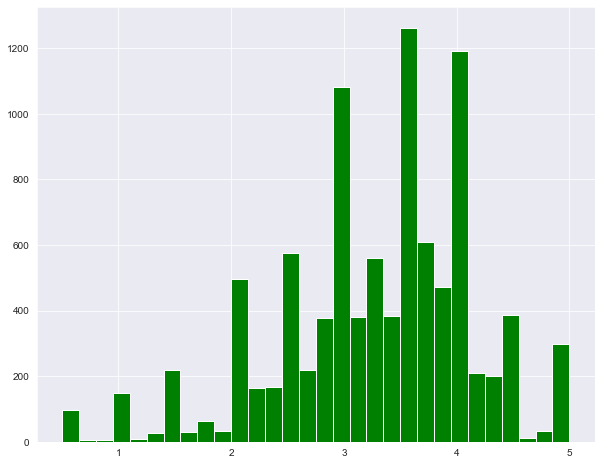

In [16]:
#plotar um histograma para ver como as avaliações médias estão distribuídas
plt.figure(figsize=(10,8))
sns.set_style('darkgrid')
movie_rating_mean_count['rating_mean'].hist(bins=30, color = 'green')

O gráfico mostra que muitos dos filmes tem avaliações entre 3 e 4. 

<AxesSubplot:>

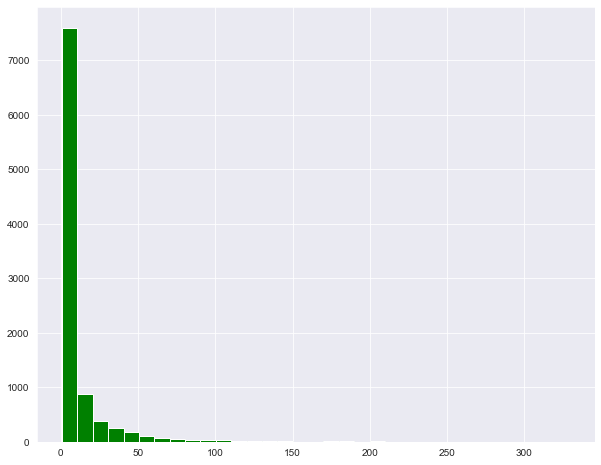

In [17]:
#plotar a distribuição dos contadores de avaliação 
plt.figure(figsize=(10,8))
sns.set_style('darkgrid')
movie_rating_mean_count['rating_count'].hist(bins=33, color ='green')

O gráfico mostra que há em torno de 7000 filmes com menos de 10 avaliações.

<AxesSubplot:xlabel='rating_mean', ylabel='rating_count'>

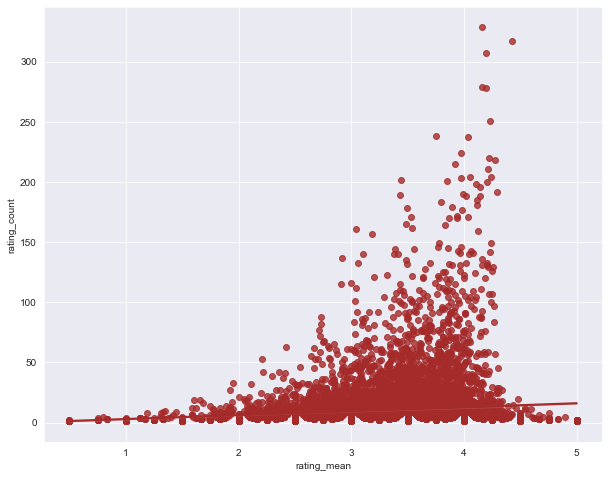

In [18]:
#relação entre as avaliações médias e o contador de avalições de um filme
plt.figure(figsize=(10,8))
sns.set_style('darkgrid')
sns.regplot(x='rating_mean', y='rating_count', data=movie_rating_mean_count, color = 'brown')


Pode se observar que com o maior número de contadores de avaliação maior a avaliação média 

In [19]:
#Ordenar o dataset pelo contador de avaliações e ver as avaliações médias dos filmes com os top 5 maiores números de avaliações. 
movie_rating_mean_count.sort_values('rating_count', ascending=False).head()

,rating_mean,rating_count
title,,
Forrest Gump (1994),4.164134,329
"Shawshank Redemption, The (1994)",4.429022,317
Pulp Fiction (1994),4.197068,307
"Silence of the Lambs, The (1991)",4.161290,279
"Matrix, The (1999)",4.192446,278


Filmes recomendados baseados na filtragem colaborativa por item. 

Será utilizado as avaliações médias como característica comum do filtro

In [20]:
user_movie_rating_matrix = merged_movie_df.pivot_table(index='userId', columns='title', values='rating')
user_movie_rating_matrix

title,'71 (2014),'Hellboy': The Seeds of Creation (2004),'Round Midnight (1986),'Salem's Lot (2004),'Til There Was You (1997),'Tis the Season for Love (2015),"'burbs, The (1989)",'night Mother (1986),(500) Days of Summer (2009),*batteries not included (1987),...,Zulu (2013),[REC] (2007),[REC]² (2009),[REC]³ 3 Génesis (2012),anohana: The Flower We Saw That Day - The Movie (2013),eXistenZ (1999),xXx (2002),xXx: State of the Union (2005),¡Three Amigos! (1986),À nous la liberté (Freedom for Us) (1931)
userId,,,,,,,,,,,,,,,,,,,,,
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
606,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
607,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
608,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,4.5,3.5,NaN,NaN,NaN


In [21]:
user_movie_rating_matrix.shape

(610, 9719)

Encontrar recomendações baseada em um único filme. Se quisermos encontrar um filme baseado no filme Pulp Fiction

In [22]:
#Filtrar a coluna que contém as avaliações dos usuários para o filme.
pulp_fiction_ratings = user_movie_rating_matrix['Pulp Fiction (1994)']

In [23]:
#Encontrar a correlação entre as avaliações de usuário de todos os filmes e a avaliação de usuário para o filme pulp fiction
pulp_fiction_correlations = pd.DataFrame(user_movie_rating_matrix.corrwith(pulp_fiction_ratings), columns=["pf_corr"])
#criou correlação entre user_movie_rating_matrix e pulp_fiction_ratings e coloca em pf_corr

D:\anaconda\lib\site-packages\numpy\lib\function_base.py:2634: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
D:\anaconda\lib\site-packages\numpy\lib\function_base.py:2493: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)


In [24]:
#ordena os valores em ordem crescente
pulp_fiction_correlations.sort_values('pf_corr', ascending=False).head()

,pf_corr
title,
Rare Exports: A Christmas Tale (Rare Exports) (2010),1.0
Azumi (2003),1.0
"Maxed Out: Hard Times, Easy Credit and the Era of Predatory Lenders (2006)",1.0
"War Zone, The (1999)",1.0
"Wolfman, The (2010)",1.0


Além da correlação entre filmes (estrelas) considerar a correlação da quantidade de estrelas. 

In [25]:
pulp_fiction_correlations.head()

,pf_corr
title,
'71 (2014),NaN
'Hellboy': The Seeds of Creation (2004),NaN
'Round Midnight (1986),NaN
'Salem's Lot (2004),NaN
'Til There Was You (1997),NaN


In [26]:
# Adicionar contador de estrelas no dataframe
pulp_fiction_correlations = pulp_fiction_correlations.join(movie_rating_mean_count['rating_count'])
pulp_fiction_correlations.head()

,pf_corr,rating_count
title,,
'71 (2014),NaN,1
'Hellboy': The Seeds of Creation (2004),NaN,1
'Round Midnight (1986),NaN,2
'Salem's Lot (2004),NaN,1
'Til There Was You (1997),NaN,2


In [27]:
#Remover os filmes que não possuem correção com PulpFiction
pulp_fiction_correlations.dropna(inplace=True)

In [28]:
#Plotar filmes que possuem mais alta correlação com PulpFiction
pulp_fiction_correlations.sort_values("pf_corr", ascending=False).head(5)

,pf_corr,rating_count
title,,
Rare Exports: A Christmas Tale (Rare Exports) (2010),1.0,2
Azumi (2003),1.0,2
"Maxed Out: Hard Times, Easy Credit and the Era of Predatory Lenders (2006)",1.0,2
"War Zone, The (1999)",1.0,2
"Wolfman, The (2010)",1.0,2


In [29]:
pulp_fiction_correlations.shape

(4878, 2)

Alta correlação, mas com baixo contador de avaliação e não dá uma visão da similaridade entre movies

In [30]:
#melhor modo: encontrar filmes com contador de avaliação de no mínimo 50 e tendo alta correlação com PulpFiction
pulp_fiction_correlations_50 = pulp_fiction_correlations[pulp_fiction_correlations['rating_count']> 50]

pulp_fiction_correlations_50.shape

(437, 2)

In [31]:
pulp_fiction_correlations_50.sort_values('pf_corr', ascending=False).head()

,pf_corr,rating_count
title,,
Pulp Fiction (1994),1.000000,307
"Wolf of Wall Street, The (2013)",0.579915,54
Fight Club (1999),0.543465,218
Kill Bill: Vol. 1 (2003),0.504147,131
Interstellar (2014),0.503411,73


Sistema de recomendação baseado em múltiplos filmes

In [32]:
#Criar um dataframe com a correlação de todos os filmes
#min_periods = 50 , avaliado por no mínimo 50 usuários
all_movie_correlations = user_movie_rating_matrix.corr(method='pearson', min_periods=50)
all_movie_correlations.head()

title,'71 (2014),'Hellboy': The Seeds of Creation (2004),'Round Midnight (1986),'Salem's Lot (2004),'Til There Was You (1997),'Tis the Season for Love (2015),"'burbs, The (1989)",'night Mother (1986),(500) Days of Summer (2009),*batteries not included (1987),...,Zulu (2013),[REC] (2007),[REC]² (2009),[REC]³ 3 Génesis (2012),anohana: The Flower We Saw That Day - The Movie (2013),eXistenZ (1999),xXx (2002),xXx: State of the Union (2005),¡Three Amigos! (1986),À nous la liberté (Freedom for Us) (1931)
title,,,,,,,,,,,,,,,,,,,,,
'71 (2014),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
'Hellboy': The Seeds of Creation (2004),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
'Round Midnight (1986),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
'Salem's Lot (2004),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
'Til There Was You (1997),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [33]:
#Criação de um usuário de teste com suas avaliações
movie_data = [['Forrest Gump (1994)', 4.0], ['Fight Club (1999)', 3.5], ['Interstellar (2014)', 4.0]]
test_movies = pd.DataFrame(movie_data, columns = ['Movie_Name', 'Movie_Rating'])
test_movies.head()

,Movie_Name,Movie_Rating
0,Forrest Gump (1994),4.0
1,Fight Club (1999),3.5
2,Interstellar (2014),4.0


Recomendar filmes do dataset para esses 3 filmes

In [34]:
#Para obter o nome e avaliação de um filme no test_movie dataframe
print(test_movies['Movie_Name'][0])
print(test_movies['Movie_Rating'][0])

Forrest Gump (1994)
4.0


In [35]:
#De todas as correlações obter as relacionadas ao filme do Forrest
all_movie_correlations['Forrest Gump (1994)'].dropna()

title
2001: A Space Odyssey (1968)                  0.191558
300 (2007)                                    0.321523
40-Year-Old Virgin, The (2005)                0.156517
Ace Ventura: Pet Detective (1994)             0.137870
Ace Ventura: When Nature Calls (1995)         0.421868
                                                ...   
Willy Wonka & the Chocolate Factory (1971)    0.195081
Wizard of Oz, The (1939)                      0.162368
X-Men (2000)                                  0.200786
X2: X-Men United (2003)                       0.246717
Young Frankenstein (1974)                     0.230049
Name: Forrest Gump (1994), Length: 313, dtype: float64

In [36]:
all_movie_correlations.shape

(9719, 9719)

In [37]:
recommended_movies = pd.Series()
for i in range(0, 2):
    movie = all_movie_correlations[test_movies['Movie_Name'][i]].dropna()
    movie = movie.map(lambda movie_corr: movie_corr * test_movies['Movie_Rating'][i])
    recommended_movies = recommended_movies.append(movie)

C:\Users\shigu\AppData\Local\Temp/ipykernel_22028/81904565.py:1: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  recommended_movies = pd.Series()


In [38]:
recommended_movies

2001: A Space Odyssey (1968)                  0.766231
300 (2007)                                    1.286094
40-Year-Old Virgin, The (2005)                0.626066
Ace Ventura: Pet Detective (1994)             0.551479
Ace Ventura: When Nature Calls (1995)         1.687472
                                                ...   
Who Framed Roger Rabbit? (1988)               0.874334
Willy Wonka & the Chocolate Factory (1971)    0.663971
Wizard of Oz, The (1939)                     -0.971160
X-Men (2000)                                 -0.063318
X2: X-Men United (2003)                      -0.661265
Length: 529, dtype: float64

In [39]:
#ordernar os filmes em ordem descendente
recommended_movies.sort_values(inplace= True, ascending= False)
print (recommended_movies.head(10))

Forrest Gump (1994)                           4.000000
Fight Club (1999)                             3.500000
Mr. Holland's Opus (1995)                     2.608575
Lock, Stock & Two Smoking Barrels (1998)      2.570366
Django Unchained (2012)                       2.225161
Life Is Beautiful (La Vita è bella) (1997)    2.203741
Pocahontas (1995)                             2.200471
Big (1988)                                    1.969404
Good Will Hunting (1997)                      1.936169
Pulp Fiction (1994)                           1.902128
dtype: float64
